In [2]:
import re
import pandas as pd
import pdfplumber

In [3]:
!ls

01-practice.pdf                         2_RBWO_providers_DallaStella.csv
03-pdfplumber-practice.ipynb            RBWO_FY2014_Provider_Profile_Guide.pdf
1a_TABULA_viewPreviousYearsPDF.csv      RBWO_providers_DallaStella.csv
1b_PDFPLUMBER_viewPreviouYearsPDF.ipynb viewPreviousYearsPDF.pdf
2_PDFPLUMBER_RBWO_providers.ipynb


In [4]:
pdf = pdfplumber.open("viewPreviousYearsPDF.pdf")

In [5]:
len(pdf.pages)

16

In [6]:
page = pdf.pages[0]

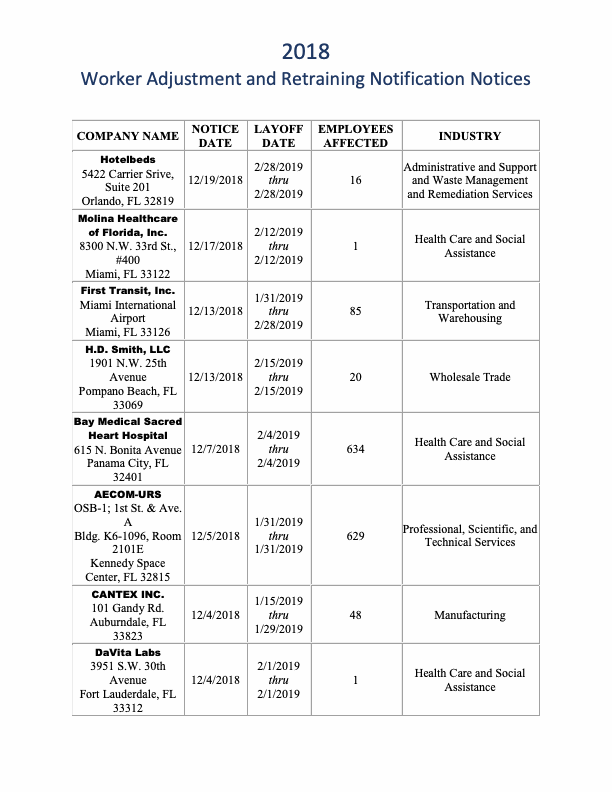

In [7]:
im = page.to_image()
im

### Extracting the header

First I will extrat the header from the first page. Because it has a different color than the rest of the file, I will use that aspect to isolate it and then regular expressions to extract the year and the text.

In [8]:
char_colors = pd.DataFrame(page.chars)["non_stroking_color"].astype(str)

char_colors.value_counts()

(0,)                    1189
(0.122, 0.22, 0.392)      61
Name: non_stroking_color, dtype: int64

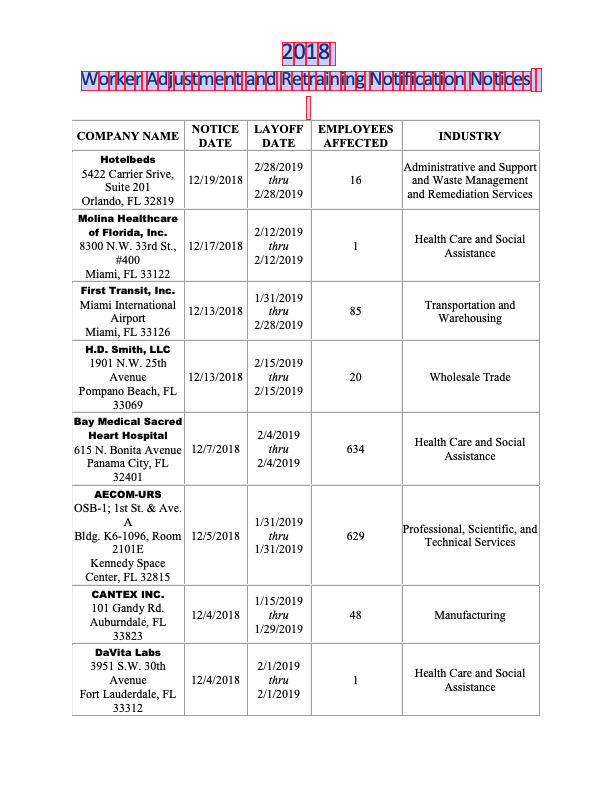

In [9]:
blue_chars = [c for c in page.chars
    if c["non_stroking_color"] == (0.122, 0.22, 0.392)]

im.reset().draw_rects(blue_chars)

In [10]:
def is_blue(obj):
    return obj.get("non_stroking_color") == (0.122, 0.22, 0.392)

header = page.filter(is_blue)
header = header.extract_text()
print(header)

2018
Worker Adjustment and Retraining Notification Notices


In [11]:
year = re.findall("\d", header)[0]
print(year)

2


In [12]:
title = re.findall("\D+", header)[0]
title = title.replace('\n', '')
title

'Worker Adjustment and Retraining Notification Notices'

### Extracting the table

Let's first try extract the table from the first page. We will then try to create a loop over the various pages.

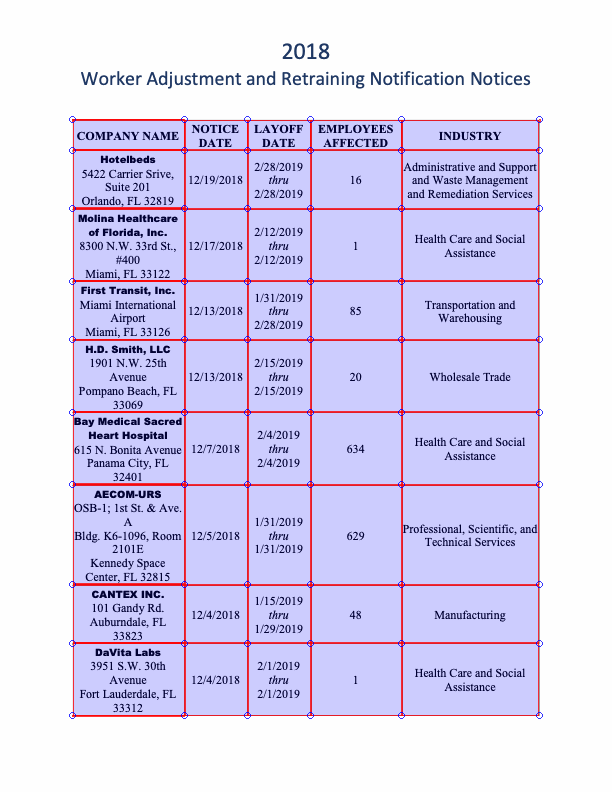

In [13]:
im.reset().debug_tablefinder()

In [14]:
print(set(char["fontname"] for char in pdf.chars))

{'TimesNewRomanPS-BoldMT', 'TimesNewRomanPS-ItalicMT', 'TimesNewRomanPSMT', 'GAERMB+Calibri', 'Arial-Black'}


In [15]:
char_fonts = pd.DataFrame(page.chars)["fontname"].astype(str)
char_fonts


0          GAERMB+Calibri
1          GAERMB+Calibri
2          GAERMB+Calibri
3          GAERMB+Calibri
4          GAERMB+Calibri
              ...        
1245    TimesNewRomanPSMT
1246    TimesNewRomanPSMT
1247    TimesNewRomanPSMT
1248    TimesNewRomanPSMT
1249    TimesNewRomanPSMT
Name: fontname, Length: 1250, dtype: object

In [18]:
def is_bold(obj):
    return obj.get("fontname") == ("Arial-Black")

company_names = page.filter(is_bold)
company_names = company_names.extract_text()
print(company_names)

Hotelbeds
Molina Healthcare
of Florida, Inc.
First Transit, Inc.
H.D. Smith, LLC
Bay Medical Sacred
Heart Hospital
AECOM-URS
CANTEX INC.
DaVita Labs


In [19]:
page.extract_tables()

[[['COMPANY NAME',
   'NOTICE\nDATE',
   'LAYOFF\nDATE',
   'EMPLOYEES\nAFFECTED',
   'INDUSTRY'],
  ['Hotelbeds\n5422 Carrier Srive,\nSuite 201\nOrlando, FL 32819',
   '12/19/2018',
   '2/28/2019\nthru\n2/28/2019',
   '16',
   'Administrative and Support\nand Waste Management\nand Remediation Services'],
  ['Molina Healthcare\nof Florida, Inc.\n8300 N.W. 33rd St.,\n#400\nMiami, FL 33122',
   '12/17/2018',
   '2/12/2019\nthru\n2/12/2019',
   '1',
   'Health Care and Social\nAssistance'],
  ['First Transit, Inc.\nMiami International\nAirport\nMiami, FL 33126',
   '12/13/2018',
   '1/31/2019\nthru\n2/28/2019',
   '85',
   'Transportation and\nWarehousing'],
  ['H.D. Smith, LLC\n1901 N.W. 25th\nAvenue\nPompano Beach, FL\n33069',
   '12/13/2018',
   '2/15/2019\nthru\n2/15/2019',
   '20',
   'Wholesale Trade'],
  ['Bay Medical Sacred\nHeart Hospital\n615 N. Bonita Avenue\nPanama City, FL\n32401',
   '12/7/2018',
   '2/4/2019\nthru\n2/4/2019',
   '634',
   'Health Care and Social\nAssistance

In [20]:
rows = page.extract_table()

pd.DataFrame(rows[1:], columns=rows[0])

,COMPANY NAME,NOTICE\nDATE,LAYOFF\nDATE,EMPLOYEES\nAFFECTED,INDUSTRY
0,"Hotelbeds\n5422 Carrier Srive,\nSuite 201\nOrl...",12/19/2018,2/28/2019\nthru\n2/28/2019,16,Administrative and Support\nand Waste Manageme...
1,"Molina Healthcare\nof Florida, Inc.\n8300 N.W....",12/17/2018,2/12/2019\nthru\n2/12/2019,1,Health Care and Social\nAssistance
2,"First Transit, Inc.\nMiami International\nAirp...",12/13/2018,1/31/2019\nthru\n2/28/2019,85,Transportation and\nWarehousing
3,"H.D. Smith, LLC\n1901 N.W. 25th\nAvenue\nPompa...",12/13/2018,2/15/2019\nthru\n2/15/2019,20,Wholesale Trade
4,Bay Medical Sacred\nHeart Hospital\n615 N. Bon...,12/7/2018,2/4/2019\nthru\n2/4/2019,634,Health Care and Social\nAssistance
5,AECOM-URS\nOSB-1; 1st St. & Ave.\nA\nBldg. K6-...,12/5/2018,1/31/2019\nthru\n1/31/2019,629,"Professional, Scientific, and\nTechnical Services"
6,"CANTEX INC.\n101 Gandy Rd.\nAuburndale, FL\n33823",12/4/2018,1/15/2019\nthru\n1/29/2019,48,Manufacturing
7,DaVita Labs\n3951 S.W. 30th\nAvenue\nFort Laud...,12/4/2018,2/1/2019\nthru\n2/1/2019,1,Health Care and Social\nAssistance


The table seems to need some cleaning. We will do it afterwards. First, let's get the tables from the rest of the file and combine them.

In [21]:
tables = []

for page in pdf.pages:
    table = page.extract_table()
    df = pd.DataFrame(table)
    tables.append(df)
    
df = pd.concat(tables, axis=0, ignore_index=True)

In [22]:
df.head()

,0,1,2,3,4
0,COMPANY NAME,NOTICE\nDATE,LAYOFF\nDATE,EMPLOYEES\nAFFECTED,INDUSTRY
1,"Hotelbeds\n5422 Carrier Srive,\nSuite 201\nOrl...",12/19/2018,2/28/2019\nthru\n2/28/2019,16,Administrative and Support\nand Waste Manageme...
2,"Molina Healthcare\nof Florida, Inc.\n8300 N.W....",12/17/2018,2/12/2019\nthru\n2/12/2019,1,Health Care and Social\nAssistance
3,"First Transit, Inc.\nMiami International\nAirp...",12/13/2018,1/31/2019\nthru\n2/28/2019,85,Transportation and\nWarehousing
4,"H.D. Smith, LLC\n1901 N.W. 25th\nAvenue\nPompa...",12/13/2018,2/15/2019\nthru\n2/15/2019,20,Wholesale Trade


In [23]:
df.columns = df.iloc[0]  # Make the first row as the header
df = df.iloc[1:]  # Take the data except for the first row
df.head()

,COMPANY NAME,NOTICE\nDATE,LAYOFF\nDATE,EMPLOYEES\nAFFECTED,INDUSTRY
1,"Hotelbeds\n5422 Carrier Srive,\nSuite 201\nOrl...",12/19/2018,2/28/2019\nthru\n2/28/2019,16,Administrative and Support\nand Waste Manageme...
2,"Molina Healthcare\nof Florida, Inc.\n8300 N.W....",12/17/2018,2/12/2019\nthru\n2/12/2019,1,Health Care and Social\nAssistance
3,"First Transit, Inc.\nMiami International\nAirp...",12/13/2018,1/31/2019\nthru\n2/28/2019,85,Transportation and\nWarehousing
4,"H.D. Smith, LLC\n1901 N.W. 25th\nAvenue\nPompa...",12/13/2018,2/15/2019\nthru\n2/15/2019,20,Wholesale Trade
5,Bay Medical Sacred\nHeart Hospital\n615 N. Bon...,12/7/2018,2/4/2019\nthru\n2/4/2019,634,Health Care and Social\nAssistance


It seems like the table is there, but it might need some cleaning.

In [24]:
# Remove \n and replace with space

df = df.replace('\n', ' ', regex=True)
df

,COMPANY NAME,NOTICE\nDATE,LAYOFF\nDATE,EMPLOYEES\nAFFECTED,INDUSTRY
1,"Hotelbeds 5422 Carrier Srive, Suite 201 Orland...",12/19/2018,2/28/2019 thru 2/28/2019,16,Administrative and Support and Waste Managemen...
2,"Molina Healthcare of Florida, Inc. 8300 N.W. 3...",12/17/2018,2/12/2019 thru 2/12/2019,1,Health Care and Social Assistance
3,"First Transit, Inc. Miami International Airpor...",12/13/2018,1/31/2019 thru 2/28/2019,85,Transportation and Warehousing
4,"H.D. Smith, LLC 1901 N.W. 25th Avenue Pompano ...",12/13/2018,2/15/2019 thru 2/15/2019,20,Wholesale Trade
5,Bay Medical Sacred Heart Hospital 615 N. Bonit...,12/7/2018,2/4/2019 thru 2/4/2019,634,Health Care and Social Assistance
...,...,...,...,...,...
129,Kmart Store #04311 1602 E. Brandon Blvd. Brand...,1/9/2018,4/1/2018 thru 4/15/2018,85,Retail Trade
130,"Brookdale Senior Living, Inc. 5600 Lakeside Dr...",1/8/2018,3/9/2018 thru 3/25/2018,110,Health Care and Social Assistance
131,Kmart Store # 04420 3711 E. Silver Spring Blvd...,1/8/2018,4/8/2018 thru 4/22/2018,64,Retail Trade
132,Macy's Downtown Miami Store 22 East Flagler St...,1/8/2018,3/18/2018 thru 3/31/2018,161,Retail Trade


In [25]:
#rename coulumns
df.columns

Index(['COMPANY NAME', 'NOTICE\nDATE', 'LAYOFF\nDATE', 'EMPLOYEES\nAFFECTED',
       'INDUSTRY'],
      dtype='object', name=0)

In [26]:
df.columns = [
    'company_address',
    'notice_date',
    'layoff_date',
    'employees_affected',
    'industry'
]
df

,company_address,notice_date,layoff_date,employees_affected,industry
1,"Hotelbeds 5422 Carrier Srive, Suite 201 Orland...",12/19/2018,2/28/2019 thru 2/28/2019,16,Administrative and Support and Waste Managemen...
2,"Molina Healthcare of Florida, Inc. 8300 N.W. 3...",12/17/2018,2/12/2019 thru 2/12/2019,1,Health Care and Social Assistance
3,"First Transit, Inc. Miami International Airpor...",12/13/2018,1/31/2019 thru 2/28/2019,85,Transportation and Warehousing
4,"H.D. Smith, LLC 1901 N.W. 25th Avenue Pompano ...",12/13/2018,2/15/2019 thru 2/15/2019,20,Wholesale Trade
5,Bay Medical Sacred Heart Hospital 615 N. Bonit...,12/7/2018,2/4/2019 thru 2/4/2019,634,Health Care and Social Assistance
...,...,...,...,...,...
129,Kmart Store #04311 1602 E. Brandon Blvd. Brand...,1/9/2018,4/1/2018 thru 4/15/2018,85,Retail Trade
130,"Brookdale Senior Living, Inc. 5600 Lakeside Dr...",1/8/2018,3/9/2018 thru 3/25/2018,110,Health Care and Social Assistance
131,Kmart Store # 04420 3711 E. Silver Spring Blvd...,1/8/2018,4/8/2018 thru 4/22/2018,64,Retail Trade
132,Macy's Downtown Miami Store 22 East Flagler St...,1/8/2018,3/18/2018 thru 3/31/2018,161,Retail Trade


In [27]:
df.head(20)

,company_address,notice_date,layoff_date,employees_affected,industry
1,"Hotelbeds 5422 Carrier Srive, Suite 201 Orland...",12/19/2018,2/28/2019 thru 2/28/2019,16,Administrative and Support and Waste Managemen...
2,"Molina Healthcare of Florida, Inc. 8300 N.W. 3...",12/17/2018,2/12/2019 thru 2/12/2019,1,Health Care and Social Assistance
3,"First Transit, Inc. Miami International Airpor...",12/13/2018,1/31/2019 thru 2/28/2019,85,Transportation and Warehousing
4,"H.D. Smith, LLC 1901 N.W. 25th Avenue Pompano ...",12/13/2018,2/15/2019 thru 2/15/2019,20,Wholesale Trade
5,Bay Medical Sacred Heart Hospital 615 N. Bonit...,12/7/2018,2/4/2019 thru 2/4/2019,634,Health Care and Social Assistance
6,AECOM-URS OSB-1; 1st St. & Ave. A Bldg. K6-109...,12/5/2018,1/31/2019 thru 1/31/2019,629,"Professional, Scientific, and Technical Services"
7,"CANTEX INC. 101 Gandy Rd. Auburndale, FL 33823",12/4/2018,1/15/2019 thru 1/29/2019,48,Manufacturing
8,DaVita Labs 3951 S.W. 30th Avenue Fort Lauderd...,12/4/2018,2/1/2019 thru 2/1/2019,1,Health Care and Social Assistance
9,"Ricoh USA, Inc. 3050 Venture Lane Bays, 101-10...",12/4/2018,1/29/2019 thru 1/29/2019,76,Wholesale Trade
10,"Molina Healthcare of Florida, Inc. 3450 Buschw...",11/30/2018,2/1/2019 thru 2/1/2019,1,Health Care and Social Assistance


We can see in row 17 that some table rows are split into two rows because of how the pdf was formatted. Maybe that's something that happened elsewhere.

In [34]:
pd.DataFrame(company_names)

ValueError: DataFrame constructor not properly called!

In [28]:
df['company_name'] = company_names
df

,company_address,notice_date,layoff_date,employees_affected,industry,company_name
1,"Hotelbeds 5422 Carrier Srive, Suite 201 Orland...",12/19/2018,2/28/2019 thru 2/28/2019,16,Administrative and Support and Waste Managemen...,"Hotelbeds\nMolina Healthcare\nof Florida, Inc...."
2,"Molina Healthcare of Florida, Inc. 8300 N.W. 3...",12/17/2018,2/12/2019 thru 2/12/2019,1,Health Care and Social Assistance,"Hotelbeds\nMolina Healthcare\nof Florida, Inc...."
3,"First Transit, Inc. Miami International Airpor...",12/13/2018,1/31/2019 thru 2/28/2019,85,Transportation and Warehousing,"Hotelbeds\nMolina Healthcare\nof Florida, Inc...."
4,"H.D. Smith, LLC 1901 N.W. 25th Avenue Pompano ...",12/13/2018,2/15/2019 thru 2/15/2019,20,Wholesale Trade,"Hotelbeds\nMolina Healthcare\nof Florida, Inc...."
5,Bay Medical Sacred Heart Hospital 615 N. Bonit...,12/7/2018,2/4/2019 thru 2/4/2019,634,Health Care and Social Assistance,"Hotelbeds\nMolina Healthcare\nof Florida, Inc...."
...,...,...,...,...,...,...
129,Kmart Store #04311 1602 E. Brandon Blvd. Brand...,1/9/2018,4/1/2018 thru 4/15/2018,85,Retail Trade,"Hotelbeds\nMolina Healthcare\nof Florida, Inc...."
130,"Brookdale Senior Living, Inc. 5600 Lakeside Dr...",1/8/2018,3/9/2018 thru 3/25/2018,110,Health Care and Social Assistance,"Hotelbeds\nMolina Healthcare\nof Florida, Inc...."
131,Kmart Store # 04420 3711 E. Silver Spring Blvd...,1/8/2018,4/8/2018 thru 4/22/2018,64,Retail Trade,"Hotelbeds\nMolina Healthcare\nof Florida, Inc...."
132,Macy's Downtown Miami Store 22 East Flagler St...,1/8/2018,3/18/2018 thru 3/31/2018,161,Retail Trade,"Hotelbeds\nMolina Healthcare\nof Florida, Inc...."


In [22]:
df.loc[df['notice_date'] == '']

,company_name,notice_date,layoff_date,employees_affected,industry
17,"4401 Seaboard Road Orlando, FL 32808",,,,
50,"Doral/Miami, FL 33172",,,,
59,"Patrick Air Force Base, FL 32925",,,,
68,Art Institute of Ft Lauderdale 1799 S.E. 17th ...,,,,
85,"Avenue Miami Lakes, FL 33014",,,,
93,"8813 Bear Road Orlando, FL 32827",,,,
110,"Road Lake Mary, FL 32746",,,,
118,"Holdings, Inc. 12750 Citrus Ln, #300 Tampa, FL...",,,,


The problem seems to be on those eight rows. We probably have to merge them with the row right before them.

In [23]:
df.iloc[16]

company_name          4401 Seaboard Road Orlando, FL 32808
notice_date                                               
layoff_date                                               
employees_affected                                        
industry                                                  
Name: 17, dtype: object